In [142]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure, draw, pause
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import clear_output
import functools
from collections import defaultdict


In [143]:
def random_forest(width, height, vegetation_ratio=0.5, boulders=0, bouldersize=20):
    map_matrix = np.zeros((height, width))
    
    water = 0
    land = 1
    vegetation = 2
    
    for i in range(height):
        for j in range(width):
            
            # 2 tiles water padding
            if i < 2 or i > height - 3 or j < 2 or j > width - 3:
                map_matrix[i][j] = water

            # set initial vegetation
            elif random.random() < vegetation_ratio:
                map_matrix[i][j] = vegetation
            
            # set land
            else:
                map_matrix[i][j] = land
    
    for i in range(boulders):
        starting_point = [random.randint(0, height), random.randint(0, width)]
        
        for j in range(bouldersize):
            for k in range(bouldersize):
                map_matrix[(starting_point[0] + j) % height][(starting_point[1] + k) % width] = 1
        
    return map_matrix


def wind_matrix(degrees, multiplier=1):

    degrees = degrees % 360
    
    mirror = False
    if degrees > 180:
        mirror = True
        degrees -= 180
    
    n_diff = min(abs(360 - degrees), abs(360 - (degrees + 360))) / 180
    s_diff = min(abs(180 - degrees), abs(180 - (degrees + 360))) / 180
    w_diff = min(abs(270 - degrees), abs(270 - (degrees + 360))) / 180
    e_diff = min(abs(90  - degrees), abs(90  - (degrees + 360))) / 180
    
    nw_diff = min(abs(315 - degrees), abs(315 - (degrees + 360))) / 180
    ne_diff = min(abs(45  - degrees), abs(45  - (degrees + 360))) / 180
    sw_diff = min(abs(225 - degrees), abs(225 - (degrees + 360))) / 180
    se_diff = min(abs(135 - degrees), abs(135 - (degrees + 360))) / 180
    
    wind_matrix = np.zeros((3,3))
    wind_matrix[1, 1] = 1
    
    wind_matrix[0, 1] = (1 + (n_diff - .5)) ** multiplier
    wind_matrix[2, 1] = (1 + (s_diff - .5)) ** multiplier
    wind_matrix[1, 0] = (1 + (w_diff - .5)) ** multiplier
    wind_matrix[1, 2] = (1 + (e_diff - .5)) ** multiplier
    
    wind_matrix[0, 0] = (1 + (nw_diff - .5)) ** multiplier
    wind_matrix[0, 2] = (1 + (ne_diff - .5)) ** multiplier
    wind_matrix[2, 0] = (1 + (sw_diff - .5)) ** multiplier
    wind_matrix[2, 2] = (1 + (se_diff - .5)) ** multiplier
    
    if mirror:
        wind_matrix = np.flip(np.flip(wind_matrix, 0), 1)
        
    return wind_matrix / (np.ones((3, 3)) * np.max(wind_matrix))

In [144]:
# class mydefaultdict(defaultdict):
#     def __missing__(self, key):
#         self[key] = new = self.default_factory(key)
#         return new

In [145]:
class ForestFires:
    def __init__(self, map_matrix, init_burning_ratio, init_ratio_burned, wind_dir=0, wind_speed=0):
        self.map_matrix = map_matrix
        self.init_burning_ratio = init_burning_ratio
        self.init_ratio_burned = init_ratio_burned
        
        # relative coordinates of 3x3 neighbourhood kernel
        self.neigh_dirs = np.array([[-1,-1], [-1,0], [-1,1], [0,-1], [0,0], [0,1], [1,-1], [1,0], [1,1]])

        # 3x3 kernels that influence the bruning_ratio of fire
        self.neigh_mult = np.array([[.833, 1, .833], [1, 1, 1], [.833, 1, .833]])
        self.wind_matrix = wind_matrix(wind_dir, wind_speed)  
        
        # init dictionary containing vegetation population
        self.veg_population = self.set_vegetation_population(self.map_matrix)
        
    def set_vegetation_population(self, map_matrix):
#         veg_population = mydefaultdict(Vegetation)
        veg_population = defaultdict()
        map_mat = map_matrix
        x_range = len(map_matrix[0])
        y_range = len(map_matrix)
        
        rand = random.random
        
        # iterate over grid
        for y in range(y_range):
            for x in range(x_range):
                
                # if vegetation
                if map_mat[y, x] == 2:
                    
                    # initial propability of vegetation burning
                    if rand() < self.init_burning_ratio:
                        veg_population[(x,y)] = Vegetation(self.init_ratio_burned, 0, 1)
                        
                    else:
                        veg_population[(x,y)] = Vegetation(0, 0, 1)
                    
        return veg_population

        

    def update(self):
        # create a temporary dict to safely replace values in the veg_population dict later on 
        temp_population = {}
        
        # 
        rand_matrix = np.random.rand
        sumof = np.sum
        zeros = np.zeros
        
        # assign class attributes to local variables for improved lookup speed
        current_population = self.veg_population.copy()
        map_matrix = self.map_matrix
        neigh_dirs = self.neigh_dirs
        neigh_mult = self.neigh_mult
        wind_matrix = self.wind_matrix
        
        for (x,y) in current_population:
            # if current vegetation is not burned up already
            if current_population[(x,y)].ratio_burned != 1:

                # fill 3x3 neighbourhood kernel
                neigh_matrix = zeros((3,3))
                for (y_2, x_2) in neigh_dirs:
                    neigh_y = y + y_2
                    neigh_x = x + x_2

                    # add neighbour to kernel if it is vegetation
                    if map_matrix[neigh_y, neigh_x] == 2:
                        
                        neigh_matrix[y_2 + 1, x_2 + 1] = current_population[(neigh_x, neigh_y)].ratio_burned

                # calculate ratio_burned for current vegetation tile
                kernel = neigh_matrix * neigh_mult * wind_matrix
                
                # probability of a fire not counting towards burning rate of current vegetation
                kernel[kernel < rand_matrix(3,3)] = 0
                summed_matrix = sumof(kernel) 
                
                delta_burned = abs(summed_matrix - current_population[(x,y)].ratio_burned)
                
                # add new ratio_burned state to temporary dict
                temp_population[(x,y)] = Vegetation((summed_matrix if summed_matrix < 1 else 1), delta_burned, 1)
            else:
                temp_population[(x,y)] = Vegetation(1, 0, 1)
                
        # update veg_population with new ratio_burned states
        for (x, y) in temp_population:
            current_population[(x,y)] = temp_population[(x,y)]
                
        self.veg_population = current_population.copy()
        
    def visualize(self, timestep, runtime):
        current_map = self.map_matrix.copy()
        current_population = self.veg_population.copy()
        
        # update burned_ratio with gradations if they are present in matrix
        fire_gradations = []  
        for (x,y) in current_population:
            p_burned = current_population[(x,y)].ratio_burned
            d_burned = current_population[(x,y)].delta_burned
            
            if d_burned > 0:
                # start stage of fire
                if d_burned <= 0.33:
                    current_map[y][x] = 3
                    
                # middle stage of fire
                elif d_burned > 0.33 and d_burned <= 0.66:
                    current_map[y][x] = 4
                    
                # last stage of fire
                elif d_burned > 0.66:
                    current_map[y][x] = 5
                        
            elif p_burned > 0:
                # start stage of fire
                if p_burned <= 0.33:
                    current_map[y][x] = 6
                    
                # middle stage of fire
                elif p_burned > 0.33 and p_burned <= 0.66:
                    current_map[y][x] = 7
                    
                # last stage of fire
                elif p_burned > 0.66 and p_burned < 1:
                    current_map[y][x] = 8
            
                # burned up
                else:
                    current_map[y][x] = 9
        
        colorMap = ['blue', 'lightgrey', 'green', 'yellow', 'orange', 'red', 'lightgreen',  'limegreen', 'forestgreen', 'black']
        indices, colors = list(zip(*[(i, c) for i,c in enumerate(colorMap) if i in current_map]))
        
        norm = plt.Normalize(min(indices), max(indices))
        tuples = list(zip(map(norm, indices), colors))
        cmap = LinearSegmentedColormap.from_list("", tuples)
 
            
        # plot current state of matrix
        figure(num=None, figsize=(10, 10))
        plt.title(f"Timestep = {timestep}\nFrame runtime = {runtime}")
        plt.imshow(current_map, cmap=cmap, norm=norm)
        plt.show()
        clear_output(wait=True)
    
        
class Vegetation:
    def __init__(self, ratio_burned, delta_burned, height):
    
        # burning or neutral
        self.ratio_burned = ratio_burned
        self.height = height
        self.delta_burned = delta_burned

In [146]:
def forest_fire_simulation(iterations, height, width, 
                           vegetation_ratio=0.5, init_burning_ratio=0.05, init_ratio_burned=0.5, 
                           wind_dir=270, wind_speed=1):

    map_array = random_forest(width, height, vegetation_ratio=vegetation_ratio)
    
    forest_sim = ForestFires(map_array, init_burning_ratio=init_burning_ratio, init_ratio_burned=init_ratio_burned, 
                             wind_dir=wind_dir, wind_speed=wind_speed)

    iterations = iterations
    t = time.time
    prev_runtime = 0
    for i in range(iterations):
        t1 = t()
        forest_sim.update()
        forest_sim.visualize(i, prev_runtime)
        t2 = t()
        prev_runtime = t2-t1

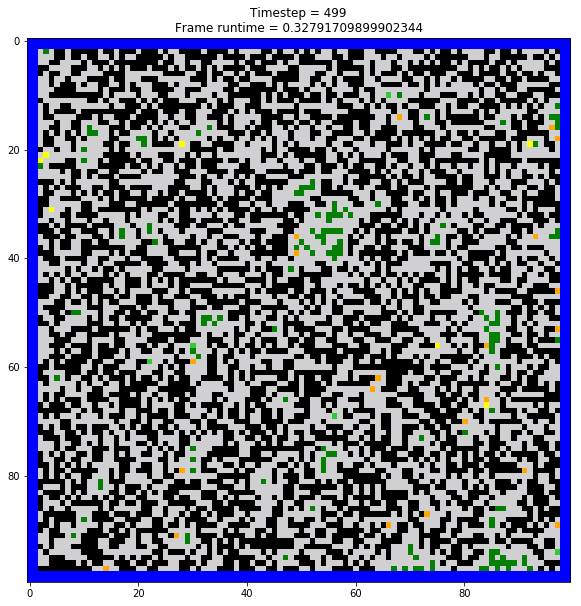

In [148]:
iterations = 500
width = 100
height = 100
vegetation_ratio = 0.5
init_burning_ratio = 0.05
init_ratio_burned = 0.9
wind_dir = 270
wind_speed = 1

forest_fire_simulation(iterations, height, width, 
                           vegetation_ratio, init_burning_ratio, init_ratio_burned, 
                           wind_dir, wind_speed)